In [18]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import OrderedDict
from CKA_functions import adjacency_matrix_motion,adjacency_matrix_distance_motion
from CKA_functions import adjacency_matrix_FACED,adjacency_matrix_distance_FACED
import math
import importlib
import SGCN_norm
importlib.reload(SGCN_norm)
from SGCN_norm import ShallowSGCNNet
from torchinfo import summary

In [19]:
in_chans = 22
n_classes = 4
input_window_samples = 1125

adj_m,pos = adjacency_matrix_motion()
#print(adj_m)
adj_dis_m, dm = adjacency_matrix_distance_motion(pos,delta=6)
dm
torch_tensor = torch.from_numpy(dm)
edge_weight = torch_tensor.reshape(-1)
print(edge_weight.shape)
model = ShallowSGCNNet(in_chans,n_classes,input_window_samples,edge_weight)

torch.Size([484])


In [20]:
print(model)

ShallowSGCNNet(
  (temporal): Conv2d(1, 40, kernel_size=(1, 25), stride=(1, 1))
  (tpool): AvgPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0)
  (tbatch_norm): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (sgconv): SimpleGCNNet(
    (sgconv): SGConv(550, 10, K=1)
  )
  (batch_norm): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): AvgPool2d(kernel_size=(1, 10), stride=(1, 10), padding=0)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=880, out_features=4, bias=True)
)


In [21]:

# Define a threshold distance below which nodes will be connected
threshold = 0  # Adjust as needed

source_nodes = []
target_nodes = []

# Iterate over all elements in the distance matrix, including self-loops and duplicates
for i in range(dm.shape[0]):
    for j in range(dm.shape[1]):  # Iterate over all pairs, including (i, i)
        if dm[i, j] >= threshold:  # If the distance meets the condition
            source_nodes.append(i)  # Source node
            target_nodes.append(j)  # Target node

# Create the edge_index tensor
edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)

print("Distance Matrix Shape:", dm.shape)
print("Edge Index:\n", edge_index.shape)

Distance Matrix Shape: (22, 22)
Edge Index:
 torch.Size([2, 484])


In [22]:
print(edge_index.shape)

torch.Size([2, 484])


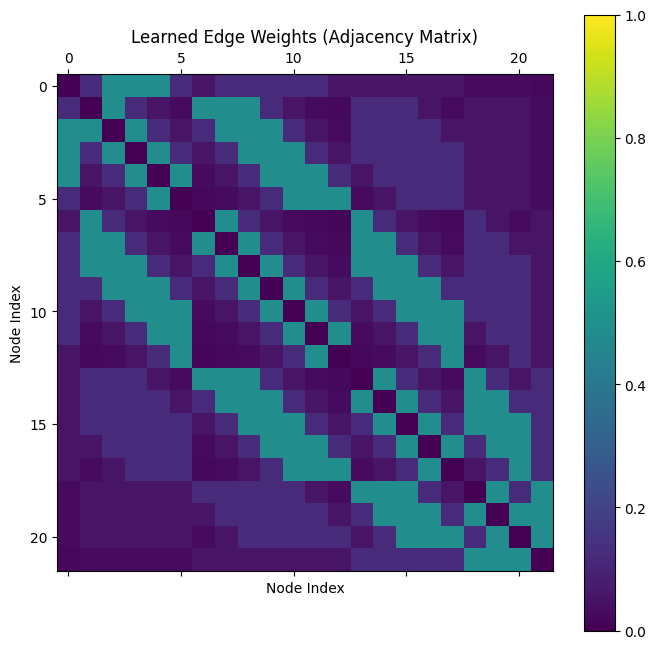

In [23]:
adj_matrix = model.sgconv.edge_weights.detach().cpu().numpy().reshape(22,22)
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.matshow(adj_matrix, cmap='viridis', interpolation='nearest',vmin=0, vmax=1)  # Adjust color map
fig.colorbar(cax)
ax.set_title("Learned Edge Weights (Adjacency Matrix)")
ax.set_xlabel("Node Index")
ax.set_ylabel("Node Index")


# Finally, show the plot
plt.show()

In [24]:
summary(model,input_size=(2, 22, 1125),edge_index=edge_index, col_names=["input_size", "output_size", "num_params", "kernel_size"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
ShallowSGCNNet                           [2, 22, 1125]             [2, 4]                    --                        --
├─Conv2d: 1-1                            [2, 1, 22, 1125]          [2, 40, 22, 1101]         1,040                     [1, 25]
├─BatchNorm2d: 1-2                       [2, 40, 22, 1101]         [2, 40, 22, 1101]         80                        --
├─AvgPool2d: 1-3                         [2, 40, 22, 1101]         [2, 40, 22, 550]          --                        [1, 2]
├─SimpleGCNNet: 1-4                      [2, 40, 22, 550]          [2, 40, 22, 10]           484                       --
│    └─SGConv: 2-1                       [2, 40, 22, 550]          [2, 40, 22, 10]           --                        --
│    │    └─SumAggregation: 3-1          [2, 40, 484, 550]         [2, 40, 22, 550]          --                        --
│    